In [84]:
import os
import imghdr
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [85]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [86]:
root_dir = 'data/'
dataset_name = 'happy vs sad'

## Create DataLoaders using Keras ImageDataGenerator

In [87]:
class ImageDataLoader(object):
    def __init__(
                self, 
                root_dir, 
                dataset_name, 
                batch_size=32, 
                img_size=224
                ):
        self.root_dir = root_dir
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.img_size = img_size

        self.remove_corrupted_images()
        self.train_ds, self.val_ds = self._load_data()
        
    def remove_corrupted_images(self):
        img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
        data_dir = os.path.join(self.root_dir, self.dataset_name)
        for dir_name in os.listdir(data_dir):
            dir_path = os.path.join(data_dir, dir_name)
            for file_name in os.listdir(dir_path):
                if not imghdr.what(os.path.join(dir_path, file_name)) in img_type_accepted_by_tf:
                    os.remove(os.path.join(dir_path, file_name))

    def _load_data(self):
        data_dir = os.path.join(self.root_dir, self.dataset_name)
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    data_dir,
                                                                    labels='inferred',
                                                                    label_mode='binary',
                                                                    color_mode='rgb',
                                                                    batch_size=self.batch_size,
                                                                    image_size=(self.img_size, self.img_size),
                                                                    shuffle=True,
                                                                    seed=42,
                                                                    validation_split=0.2,
                                                                    subset='training',
                                                                    interpolation='bilinear',
                                                                    follow_links=False,
        )
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    data_dir,
                                                                    labels='inferred',
                                                                    label_mode='binary',
                                                                    color_mode='rgb',
                                                                    batch_size=self.batch_size,
                                                                    image_size=(self.img_size, self.img_size),
                                                                    shuffle=True,
                                                                    seed=42,
                                                                    validation_split=0.2,
                                                                    subset='validation',
                                                                    interpolation='bilinear',
                                                                    follow_links=False,
                                                                )
        return train_ds, val_ds
    
    def get_train_ds(self):
        return self.train_ds
    
    def get_val_ds(self):
        return self.val_ds
    
    def show_batch(self, ds):
        plt.figure(figsize=(10, 10))
        for images, labels in ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(int(labels[i]))
                plt.axis("off")
                
    def get_class_names(self):
        return self.train_ds.class_names

In [88]:
data_obj = ImageDataLoader(root_dir, dataset_name)
class_names = data_obj.get_class_names()

print('\nClass names: ', class_names)

Found 149 files belonging to 2 classes.
Using 120 files for training.
Found 149 files belonging to 2 classes.
Using 29 files for validation.

Class names:  ['happy', 'sad']


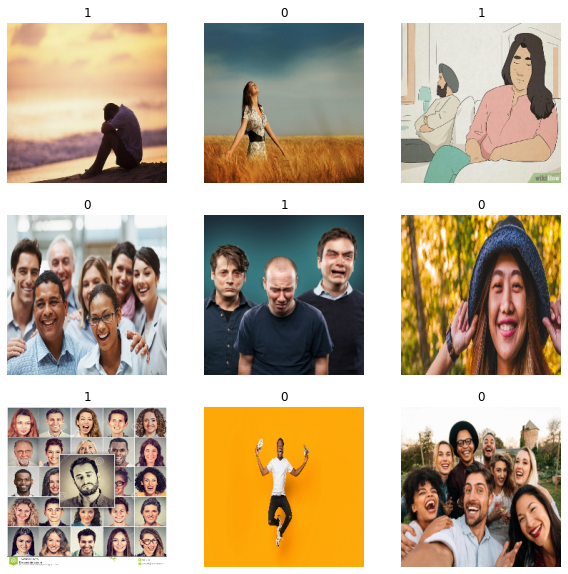

In [89]:
# visualize the data
data_obj.show_batch(data_obj.get_train_ds())

# Build the Model

In [90]:
class ImageClassifier(object):
    def __init__(
                self, 
                batch_size=12, 
                img_size=224, 
                epochs=10, 
                learning_rate=0.001, 
                momentum=0.9, 
                decay=0.0, 
                nesterov=False, 
                loss='binary_crossentropy', 
                metrics=['accuracy']
                ):
        data_obj = ImageDataLoader(root_dir, dataset_name, batch_size, img_size) 
        self.train_ds = data_obj.get_train_ds()
        self.val_ds = data_obj.get_val_ds()
        self.class_names = data_obj.get_class_names()
        self.batch_size = batch_size
        self.img_size = img_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.decay = decay
        self.nesterov = nesterov
        self.loss = loss
        self.metrics = metrics
        
        self.model = self._build_model()
        
    def _build_model(self):
        model = tf.keras.models.Sequential([
                                        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.img_size, self.img_size, 3)),
                                        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D(),
                                        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D(),
                                        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D(),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
                                        ])
        return model
    
    def _compile_model(self):
        # optimizer = tf.keras.optimizers.SGD(
        #                                     learning_rate=self.learning_rate, 
        #                                     momentum=self.momentum, 
        #                                     decay=self.decay, 
        #                                     nesterov=self.nesterov
        #                                     )
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(
                        optimizer=optimizer, 
                        loss=self.loss, 
                        metrics=self.metrics
                        )
        
    def _train_model(self):
        self._compile_model()
        history = self.model.fit(
                                self.train_ds,
                                validation_data=self.val_ds,
                                epochs=self.epochs
                                )
        return history
    
    def _plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(25, 15))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_confusion_matrix(self):
        y_pred = self.model.predict(self.val_ds)
        y_pred = np.round(y_pred)
        cm = confusion_matrix(np.concatenate([y for x, y in self.val_ds], axis=0).squeeze(), y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion matrix")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

# Training

In [91]:
train_ds = data_obj.get_train_ds()
val_ds = data_obj.get_val_ds()
class_names = data_obj.get_class_names()

In [92]:
model_obj = ImageClassifier()
history = model_obj._train_model()

Found 149 files belonging to 2 classes.
Using 120 files for training.
Found 149 files belonging to 2 classes.
Using 29 files for validation.
Epoch 1/10
10/10 [==============================] - 1s 62ms/step - loss: 0.8532 - accuracy: 0.5667 - val_loss: 0.6910 - val_accuracy: 0.4138
Epoch 2/10
10/10 [==============================] - 1s 47ms/step - loss: 0.5220 - accuracy: 0.7083 - val_loss: 0.6103 - val_accuracy: 0.6897
Epoch 3/10
10/10 [==============================] - 1s 46ms/step - loss: 0.4399 - accuracy: 0.7917 - val_loss: 0.5875 - val_accuracy: 0.6552
Epoch 4/10
10/10 [==============================] - 1s 47ms/step - loss: 0.3322 - accuracy: 0.8500 - val_loss: 0.4879 - val_accuracy: 0.8621
Epoch 5/10
10/10 [==============================] - 1s 45ms/step - loss: 0.2024 - accuracy: 0.9417 - val_loss: 0.4903 - val_accuracy: 0.7931
Epoch 6/10
10/10 [==============================] - 1s 46ms/step - loss: 0.1042 - accuracy: 0.9833 - val_loss: 0.8158 - val_accuracy: 0.6552
Epoch 7/10
10

# Evaluate the model

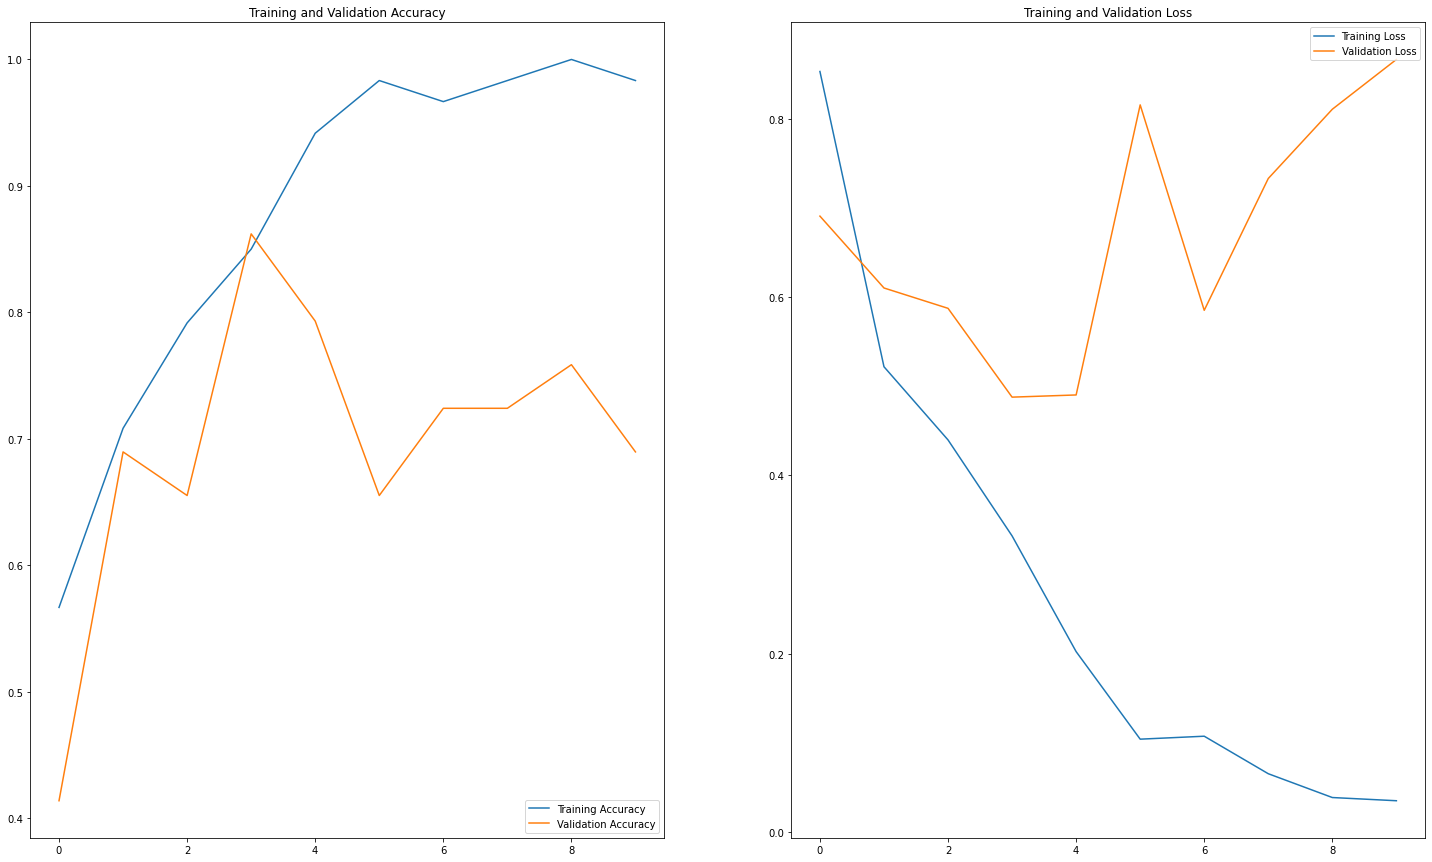

In [93]:
model_obj._plot_history(history)

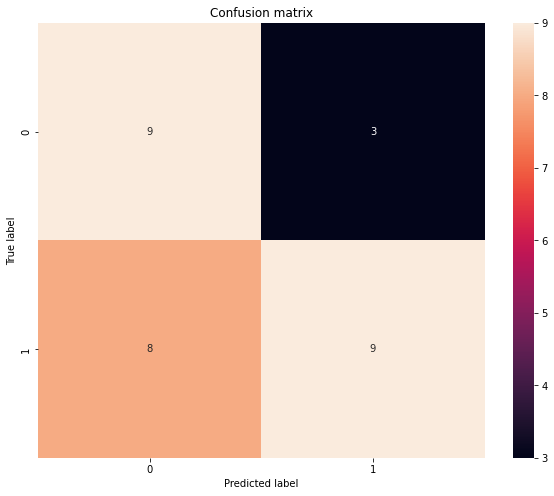

In [94]:
model_obj.plot_confusion_matrix()